No Libraries, No Shortcuts: LLM from Scratch with PyTorch

In [2]:
import torch
from torch import nn
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Self -Attention 

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, attention_dim, bias=False, dropout=0.1):
        super().__init__()
        self.w_key = nn.Linear(embed_dim, attention_dim, bias=bias)
        self.w_query = nn.Linear(embed_dim, attention_dim, bias=bias)
        self.w_value = nn.Linear(embed_dim, attention_dim, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, _ = x.size()
        """
        [
            [write vector],
            [me vector],
            [a vector],
            [poem vector],
        ]
        """

        k = self.w_key(x)   # (B, T, A)
        q = self.w_query(x) # (B, T, A)
        v = self.w_value(x) # (B, T, A)

        # Scaled dot-product attention
        scores = (q @ k.transpose(-2, -1)) / (k.size(-1) ** 0.5)  # (B, T, T)

        # Causal mask (future positions masked)
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        scores = scores.masked_fill(mask, float('-1e10'))

        attn = scores.softmax(dim=-1)  # (B, T, T)

        attn = self.dropout(attn)

        return attn @ v  # (B, T, A)

multiple attention

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, embed_dim, attention_dim, dropout=0.1):
        super().__init__()
        self.head_size = attention_dim//num_heads
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(SelfAttention(embed_dim=embed_dim, attention_dim=self.head_size,dropout=dropout))

    def forward(self,x):
        head_outputs = []
        for head in self.heads:
            head_outputs.append(head(x)) #B x T x A//num_heads
        concatenated = torch.cat(head_outputs, dim = 2)
        return concatenated


In [5]:
class FeedForward(nn.Module):
    def __init__(self,attention_dim):
        super().__init__()
        self.up = nn.Linear(attention_dim,attention_dim*4)
        self.relu = nn.GELU()
        self.down = nn.Linear(attention_dim*4,attention_dim)
    def forward(self,x):
        return self.down(self.relu(self.up(x)))


In [6]:

class Decoder(nn.Module):
    def __init__(self,num_heads,embed_dim,attention_dim, dropout=0.1):
        super().__init__()
        self.masked_multihead = MultiHeadAttention(num_heads, embed_dim, attention_dim, dropout)
        self.feed_forward = FeedForward(attention_dim)
        self.n1 = nn.LayerNorm(attention_dim)
        self.n2 = nn.LayerNorm(attention_dim)
    def forward(self,x):
        e = self.masked_multihead(self.n1(x))
        e =  e + x
        e = self.feed_forward(self.n2(e))
        return e



In [7]:
class GPT(nn.Module):
    def __init__(self, num_heads, vocab_size, embed_dim, attention_dim, num_blocks, context_length, dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, attention_dim)
        self.positional_embedding = nn.Embedding(context_length, attention_dim)

        self.decoders = nn.ModuleList([
            Decoder(num_heads, attention_dim, attention_dim, dropout_rate) for _ in range(num_blocks)
        ])

        self.exit_norm = nn.LayerNorm(attention_dim)
        self.linear = nn.Linear(attention_dim, vocab_size)

    def forward(self, context):
        embeddings = self.embedding(context)
        context_len = context.shape[1]
        position = torch.arange(context_len, device=context.device).unsqueeze(0)
        position_embeddings = self.positional_embedding(position)

        e = embeddings + position_embeddings

        for decoder in self.decoders:
            e = decoder(e)

        return self.linear(self.exit_norm(e))


In [8]:
int_to_char = {0: '\n', 1: ' ', 2: '!', 3: '"', 4: '$', 5: '%', 6: '&', 7: "'", 8: '(', 9: ')', 10: '*', 11: '+', 12: ',', 13: '-', 14: '.', 15: '/', 16: '0', 17: '1', 18: '2', 19: '3', 20: '4', 21: '5', 22: '6', 23: '7', 24: '8', 25: '9', 26: ':', 27: ';', 28: '?', 29: 'A', 30: 'B', 31: 'C', 32: 'D', 33: 'E', 34: 'F', 35: 'G', 36: 'H', 37: 'I', 38: 'J', 39: 'K', 40: 'L', 41: 'M', 42: 'N', 43: 'O', 44: 'P', 45: 'Q', 46: 'R', 47: 'S', 48: 'T', 49: 'U', 50: 'V', 51: 'W', 52: 'X', 53: 'Y', 54: 'Z', 55: '[', 56: ']', 57: '_', 58: 'a', 59: 'b', 60: 'c', 61: 'd', 62: 'e', 63: 'f', 64: 'g', 65: 'h', 66: 'i', 67: 'j', 68: 'k', 69: 'l', 70: 'm', 71: 'n', 72: 'o', 73: 'p', 74: 'q', 75: 'r', 76: 's', 77: 't', 78: 'u', 79: 'v', 80: 'w', 81: 'x', 82: 'y', 83: 'z', 84: '{', 85: '|', 86: '}', 87: 'à', 88: 'á', 89: 'è', 90: 'é', 91: 'ë', 92: 'ñ', 93: 'ó', 94: 'ú', 95: '\u2005', 96: '–', 97: '—', 98: '‘', 99: '’', 100: '“', 101: '”', 102: '…', 103: '\u205f'}

def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = float('-inf')
    return out


def generate_text(model, new_chars, context, context_length, int_to_char, temperature=1.0, top_k=None):
    res = []
    for _ in range(new_chars):
        if context.shape[1] > context_length:
            context = context[:, -context_length:]

        logits = model(context)  # [B, T, V]
        logits = logits[:, -1, :]  # [B, V]
        logits = logits / max(temperature, 1e-3)

        if top_k is not None:
            logits = top_k_logits(logits, top_k)

        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise ValueError("Logits contain NaN or Inf")

        probabilities = nn.functional.softmax(logits, dim=-1)
        probabilities = torch.clamp(probabilities, min=1e-9, max=1.0)

        next_token = torch.multinomial(probabilities, 1)  # [B, 1]
        context = torch.cat((context, next_token), dim=1)
        res.append(int_to_char[next_token.item()])

    return ''.join(res)

def generate(model, max_new_tokens, context, context_length, temperature=1.0, top_k=None):
    res = []
    for _ in range(max_new_tokens):
        if context.shape[1] > context_length:
            context = context[:, -context_length:]

        logits = model(context)  # [B, T, V]
        logits = logits[:, -1, :]  # [B, V]
        logits = logits / max(temperature, 1e-3)

        if top_k is not None:
            logits = top_k_logits(logits, top_k)

        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise ValueError("Logits contain NaN or Inf")

        probabilities = nn.functional.softmax(logits, dim=-1)
        probabilities = torch.clamp(probabilities, min=1e-9, max=1.0)

        next_token = torch.multinomial(probabilities, 1)  # [B, 1]
        context = torch.cat((context, next_token), dim=1)


    return context



In [9]:
# vocab_size = 104             # Number of tokens in your vocabulary
# context_length = 128         # Maximum sequence length (tokens)
# embed_dim = 256              # Token embedding size
# attention_dim = 256          # Attention projection dimension (keep same as embed_dim)
# num_heads = 4                # Number of attention heads (must divide attention_dim)
# num_blocks = 6               # Number of decoder blocks (layers)
# num_words = 5000
# dropout_rate=0.1           # Number of new tokens to generate (optional tuning)

# # Initial context (starting token or BOS)
# context = torch.zeros(1, 1, dtype=torch.int64).to(device)

# model = GPT(num_heads,vocab_size,embed_dim,attention_dim,num_blocks,context_length,dropout_rate).to(device)
# model.eval()

Pretraining

Dataset Preparation

In [10]:
!pip install datasets

In [11]:
!curl -X GET "https://datasets-server.huggingface.co/rows?dataset=huggingartists%2Fcoldplay&config=default&split=train&offset=0&length=100" -o coldplay_data.json
import json
import pandas as pd

with open('coldplay_data.json', 'r') as f:
    data = json.load(f)

df = pd.DataFrame(data['rows'])
display(df.head())

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  100k  100  100k    0     0  84542      0  0:00:01  0:00:01 --:--:-- 84690


,row_idx,row,truncated_cells
0,0,{'text': 'Ive been reading books of old The le...,[]
1,1,"{'text': 'Come up to meet you, tell you Im sor...",[]
2,2,{'text': 'I used to rule the world Seas would ...,[]
3,3,"{'text': 'When you try your best, but you dont...",[]
4,4,{'text': 'Look at the stars Look how they shin...,[]


In [12]:
df = df.drop(columns=['truncated_cells'])
df['text'] = df['row'].apply(lambda x: x['text'])
df = df.drop(columns=['row'])
display(df.head())

,row_idx,text
0,0,Ive been reading books of old\nThe legends and...
1,1,"Come up to meet you, tell you Im sorry\nYou do..."
2,2,I used to rule the world\nSeas would rise when...
3,3,"When you try your best, but you dont succeed\n..."
4,4,Look at the stars\nLook how they shine for you...


In [13]:
import re
# Select subsets
train_subset = df.iloc[:90]
test_subset = df.iloc[90:]

# Extract and clean lyrics
def keep_english_only(text):
    return re.sub(r"[^\x00-\x7F]+", "", text)

# Process training lyrics
train_lyrics = [keep_english_only(row["text"]) for index, row in train_subset.iterrows()]
joined_train_lyrics = '\n'.join(train_lyrics)

# Process test lyrics
test_lyrics = [keep_english_only(row["text"]) for index, row in test_subset.iterrows()]
joined_test_lyrics = '\n'.join(test_lyrics)

full_lyrics = joined_train_lyrics + '\n' + joined_test_lyrics

In [14]:
full_lyrics[:200]

'Ive been reading books of old\nThe legends and the myths\nAchilles and his gold\nHercules and his gifts\nSpider-Mans control\nAnd Batman with his fists\nAnd clearly I dont see myself upon that list\nBut she '

In [15]:
characters = list(set(full_lyrics))
len(characters)

65

Stanford IMDB

In [16]:
from datasets import load_dataset
import re

# Load dataset
ds = load_dataset("stanfordnlp/imdb")

# Function to keep only English (ASCII) characters
def keep_english_only(text):
    return re.sub(r"[^\x00-\x7F]+", "", text)

# Function to clean and combine a list of texts
def combine_and_clean(text_list):
    # Keep only English
    cleaned_list = [keep_english_only(t) for t in text_list]
    # Combine into one string
    combined = " ".join(cleaned_list)
    # Remove extra spaces/newlines
    combined = re.sub(r'\s+', ' ', combined).strip()
    return combined

# Create separate combined strings
train_text_data = combine_and_clean(ds['train']['text'][:10000])
test_text_data = combine_and_clean(ds['test']['text'][:10000])

print(f"Train text length: {len(train_text_data)} characters")
print(f"Test text length: {len(test_text_data)} characters")

# Preview first 300 chars from each
print("\nTrain preview:", train_text_data[:300])
print("\nTest preview:", test_text_data[:300])



/home/user/hackathons/52_Weeks_Challenges/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train text length: 13090602 characters
Test text length: 12929994 characters

Train preview: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really h

Test preview: I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, C


Shakespeare Karpathy

In [17]:
# from datasets import load_dataset
# import re

# # Load dataset
# ds = load_dataset("SamuelYang/bookcorpus")

# # Function to keep only English (ASCII) characters
# def keep_english_only(text):
#     return re.sub(r"[^\x00-\x7F]+", "", text)

# # Function to clean and combine a list of texts
# def combine_and_clean(text_list):
#     # Keep only English
#     cleaned_list = [keep_english_only(t) for t in text_list]
#     # Combine into one string
#     combined = " ".join(cleaned_list)
#     # Remove extra spaces/newlines
#     combined = re.sub(r'\s+', ' ', combined).strip()
#     return combined

# # Since bookcorpus has only a train split, create synthetic validation and test splits
# # Use 80% for train, 10% for validation, 10% for test
# train_size = int(0.8 * len(ds['train']['text']))
# val_size = int(0.1 * len(ds['train']['text']))
# train_text = ds['train']['text'][:train_size]
# validation_text = ds['train']['text'][train_size:train_size + val_size]
# test_text = ds['train']['text'][train_size + val_size:train_size + 2 * val_size]

# # Create combined strings for train, validation, and test
# train_text_data = combine_and_clean(train_text)
# validation_text_data = combine_and_clean(validation_text)
# test_text_data = combine_and_clean(test_text)

# # Print lengths
# print(f"Train text length: {len(train_text_data)} characters")
# print(f"Validation text length: {len(validation_text_data)} characters")
# print(f"Test text length: {len(test_text_data)} characters")

# # Preview first 300 chars from each
# print("\nTrain preview:", train_text_data[:300])
# print("\nValidation preview:", validation_text_data[:300])
# print("\nTest preview:", test_text_data[:300])

Word Tokenizer

In [18]:
# import tiktoken

# # Alternatively:
# # from llms_from_scratch.ch04 import generate_text_simple

# def text_to_token_ids(text, tokenizer, device):
#     encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
#     encoded_tensor = torch.tensor(encoded).unsqueeze(0).to(device, non_blocking=True) # add batch dimension and move to device
#     return encoded_tensor

# def token_ids_to_text(token_ids, tokenizer):
#     flat = token_ids.squeeze(0) # remove batch dimension
#     return tokenizer.decode(flat.tolist())


# start_context = "I want something"
# tokenizer = tiktoken.get_encoding("gpt2")

Custom tokenizer

In [19]:
!pip install tiktoken transformers

In [20]:
def get_training_corpus(batch_size=1000):
    """
    Yields batches of raw IMDB reviews + Coldplay lyrics
    for tokenizer training.
    """
    # Combine IMDB train + test + Coldplay lyrics
    texts = ds["train"]["text"][:] + ds["test"]["text"][:] + \
            [joined_train_lyrics, joined_test_lyrics]

    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        yield [keep_english_only(t) for t in batch]  # clean before yielding



training_corpus = get_training_corpus()
from transformers import AutoTokenizer
from transformers import GPT2Tokenizer

old_tokenizer = AutoTokenizer.from_pretrained("gpt2", local_files_only=True)
tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 5000)

In [21]:
import torch

def text_to_token_ids(text, tokenizer, device):
    """
    Convert raw text → token IDs tensor (batch size = 1).
    """
    encoded = tokenizer.encode(text, add_special_tokens=False)
    encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0)  # (1, T)
    return encoded_tensor.to(device, non_blocking=True)


def token_ids_to_text(token_ids, tokenizer):
    """
    Convert token IDs tensor → decoded text.
    """
    flat = token_ids.squeeze(0).tolist()  # remove batch dimension
    return tokenizer.decode(flat, skip_special_tokens=True)


Test model

In [22]:
vocab_size = tokenizer.vocab_size           # GPT-2 tokenizer vocab size
context_length = 128                     # Reduced context length for faster training
embed_dim = 128                        # Smaller embedding dimension
attention_dim = 128                     # Keep same as embed_dim
num_heads = 2                           # Divisible by attention_dim
num_blocks = 4                          # Fewer blocks for smaller model
dropout_rate = 0.1

# Initial context (starting token or BOS)
context = torch.zeros(1, 1, dtype=torch.int64).to(device, non_blocking=True)

model = GPT(num_heads,vocab_size,embed_dim,attention_dim,num_blocks,context_length, dropout_rate).to(device)
model.eval()

GPT(
  (embedding): Embedding(5000, 128)
  (positional_embedding): Embedding(128, 128)
  (decoders): ModuleList(
    (0-3): 4 x Decoder(
      (masked_multihead): MultiHeadAttention(
        (heads): ModuleList(
          (0-1): 2 x SelfAttention(
            (w_key): Linear(in_features=128, out_features=64, bias=False)
            (w_query): Linear(in_features=128, out_features=64, bias=False)
            (w_value): Linear(in_features=128, out_features=64, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (feed_forward): FeedForward(
        (up): Linear(in_features=128, out_features=512, bias=True)
        (relu): GELU(approximate='none')
        (down): Linear(in_features=512, out_features=128, bias=True)
      )
      (n1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (n2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (exit_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (linear): 

In [23]:
start_context="Once upon a time in hollywood,"

token_ids = generate(
    model=model,
    context=text_to_token_ids(start_context, tokenizer, device),
    max_new_tokens=10,
    context_length=context_length
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Once upon a time in hollywood, among running ann ele revenge industryric Thoughton One


Train

In [24]:
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    elif isinstance(module, nn.LayerNorm):
        torch.nn.init.ones_(module.weight)
        torch.nn.init.zeros_(module.bias)

# Apply initialization
model.apply(initialize_weights)

GPT(
  (embedding): Embedding(5000, 128)
  (positional_embedding): Embedding(128, 128)
  (decoders): ModuleList(
    (0-3): 4 x Decoder(
      (masked_multihead): MultiHeadAttention(
        (heads): ModuleList(
          (0-1): 2 x SelfAttention(
            (w_key): Linear(in_features=128, out_features=64, bias=False)
            (w_query): Linear(in_features=128, out_features=64, bias=False)
            (w_value): Linear(in_features=128, out_features=64, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (feed_forward): FeedForward(
        (up): Linear(in_features=128, out_features=512, bias=True)
        (relu): GELU(approximate='none')
        (down): Linear(in_features=512, out_features=128, bias=True)
      )
      (n1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (n2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (exit_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (linear): 

In [25]:
total_characters = len(train_text_data)
total_tokens = len(tokenizer.encode(train_text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

# Sanity check

if total_tokens * (0.95) < context_length:
    print("Not enough tokens for the training loader. "
          "Try to lower the context_length or "
          "increase the `training_ratio`")

if total_tokens * (1-0.95) <context_length:
    print("Not enough tokens for the validation loader. "
          "Try to lower the context_length or "
          "decrease the `training_ratio`")

Token indices sequence length is longer than the specified maximum sequence length for this model (3467525 > 1024). Running this sequence through the model will result in indexing errors


Characters: 13090602
Tokens: 3467525


In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



class CustomDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, add_special_tokens=False)


        # Use a sliding window to chunk the data into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_encoded_dataloader(txt, tokenizer, batch_size=4, max_length=128,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):

    # Create dataset
    dataset = CustomDataset(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers, pin_memory=True)

    return dataloader

In [27]:
# def generate_text(model, new_chars, context, context_length, temperature=1.0, top_k=None):
#     res = []
#     for _ in range(new_chars):
#         if context.shape[1] > context_length:
#             context = context[:, -context_length:]

#         logits = model(context)  # [B, T, V]
#         logits = logits[:, -1, :]  # [B, V]
#         logits = logits / max(temperature, 1e-3)

#         if top_k is not None:
#             logits = top_k_logits(logits, top_k)

#         if torch.isnan(logits).any() or torch.isinf(logits).any():
#             raise ValueError("Logits contain NaN or Inf")

#         probabilities = nn.functional.softmax(logits, dim=-1)
#         probabilities = torch.clamp(probabilities, min=1e-9, max=1.0)

#         next_token = torch.multinomial(probabilities, 1)  # [B, 1]
#         context = torch.cat((context, next_token), dim=1)
#         res.append(next_token.item())

#     return tokenizer.decode(res)

# # Function to compute gradient norm and max gradient
# def compute_gradient_stats(model):
#     total_norm = 0.0
#     max_grad = 0.0
#     for p in model.parameters():
#         if p.grad is not None:
#             param_norm = p.grad.data.norm(2).item()
#             total_norm += param_norm ** 2
#             max_grad = max(max_grad, p.grad.data.abs().max().item())
#     total_norm = total_norm ** 0.5
#     return total_norm, max_grad

# # Loss calculation function for a single batch
# def calc_loss_batch(input_batch, target_batch, model, device):
#     input_batch = input_batch.to(device, non_blocking=True)
#     target_batch = target_batch.to(device, non_blocking=True)

#     logits = model(input_batch)
#     loss = torch.nn.functional.cross_entropy(
#         logits.view(-1, vocab_size), target_batch.view(-1), ignore_index=-100
#     )
#     return loss

# # Training loop for one epoch
# def train_epoch(model, dataloader, optimizer, device):
#     model.train()
#     total_loss = 0
#     total_grad_norm = 0
#     total_max_grad = 0
#     num_batches = len(dataloader)

#     for batch_idx, batch in enumerate(dataloader):
#         loss = calc_loss_batch(batch[0], batch[1], model, device)
#         optimizer.zero_grad()
#         loss.backward()

#         # Compute gradient statistics
#         grad_norm, max_grad = compute_gradient_stats(model)
#         total_grad_norm += grad_norm
#         total_max_grad = max(total_max_grad, max_grad)

#         optimizer.step()
#         total_loss += loss.item()

#         # Print batch-level stats every 100 batches for debugging
#         if (batch_idx + 1) % 100 == 0:
#             print(f"Batch {batch_idx + 1}/{num_batches}: "
#                   f"Loss = {loss.item():.4f}, "
#                   f"Grad Norm = {grad_norm:.4f}, "
#                   f"Max Grad = {max_grad:.4f}")

#     avg_loss = total_loss / num_batches
#     avg_grad_norm = total_grad_norm / num_batches
#     avg_max_grad = total_max_grad / num_batches
#     return avg_loss, avg_grad_norm, avg_max_grad

# # Evaluation loop for one epoch
# def eval_epoch(model, dataloader, device):
#     model.eval()
#     total_loss = 0
#     num_batches = len(dataloader)

#     with torch.no_grad():
#         for batch in dataloader:
#             loss = calc_loss_batch(batch[0], batch[1], model, device)
#             total_loss += loss.item()

#     return total_loss / num_batches

# # Main training function with early stopping
# def main(settings):
#     optimizer = torch.optim.AdamW(model.parameters(), lr=settings["learning_rate"], weight_decay=settings["weight_decay"], betas=(0.9, 0.95))

#     best_val_loss = float('inf')
#     patience_counter = 0
#     best_model_path = "gpt_model_best.pth"

#     for epoch in range(settings["num_epochs"]):
#         train_loss, train_grad_norm, train_max_grad = train_epoch(model, train_dataloader, optimizer, device)
#         val_loss = eval_epoch(model, test_dataloader, device)

#         if (epoch + 1) % settings["print_interval"] == 0:
#             print(f"Epoch {epoch + 1}/{settings['num_epochs']}: "
#                   f"Train Loss = {train_loss:.4f}, "
#                   f"Val Loss = {val_loss:.4f}, "
#                   f"Avg Grad Norm = {train_grad_norm:.4f}, "
#                   f"Max Grad = {train_max_grad:.4f}, "
#                   f"Learning Rate = {settings['learning_rate']:.6f}")

#         # Early stopping check
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             patience_counter = 0
#             torch.save(model.state_dict(), best_model_path)
#             print(f"Saved best model with validation loss {best_val_loss:.4f}")
#         else:
#             patience_counter += 1
#             print(f"No improvement in validation loss. Patience counter: {patience_counter}/{settings['patience']}")
#             if patience_counter >= settings["patience"]:
#                 print(f"Early stopping triggered after {epoch + 1} epochs.")
#                 break

#         if (epoch + 1) % settings["generate_interval"] == 0:
#             start_context = "This is a test generation: "
#             context = text_to_token_ids(start_context, tokenizer, device)
#             generated = generate_text(model, 100, context, context_length, temperature=0.7)
#             print(f"Generated text after epoch {epoch + 1}:\n{start_context + generated}\n")

#     # Load the best model
#     model.load_state_dict(torch.load(best_model_path))
#     print(f"Training completed. Best model loaded from '{best_model_path}' with validation loss {best_val_loss:.4f}.")



In [28]:
import math
import os
import torch
from torch import nn

# ---------- Loss helpers ----------
criterion = nn.CrossEntropyLoss()

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device, non_blocking=True)
    target_batch = target_batch.to(device, non_blocking=True)

    logits = model(input_batch)  # [B, T, V]
    B, T, V = logits.shape
    loss = criterion(logits.view(B * T, V), target_batch.view(B * T))
    return loss


@torch.no_grad()
def calc_loss_loader(data_loader, model, device, num_batches=None):
    if len(data_loader) == 0:
        return float("nan")

    model.eval()
    total_loss = 0.0
    num_batches = len(data_loader) if num_batches is None else min(num_batches, len(data_loader))

    for i, (inp, tgt) in enumerate(data_loader):
        if i >= num_batches:
            break
        loss = calc_loss_batch(inp, tgt, model, device)
        total_loss += loss.item()

    model.train()
    return total_loss / num_batches


@torch.no_grad()
def evaluate_model(model, train_loader, val_loader, device, eval_iter=1):
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss   = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    return train_loss, val_loss


# ---------- Cosine LR with Warmup ----------
class CosineWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, base_lr, min_lr, last_epoch=-1):
        self.warmup_steps = max(1, warmup_steps)
        self.total_steps = max(self.warmup_steps + 1, total_steps)
        self.base_lr = base_lr
        self.min_lr = min_lr
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        lrs = []
        for _ in self.base_lrs:
            if step <= self.warmup_steps:
                lr = self.base_lr * step / self.warmup_steps
            else:
                progress = (step - self.warmup_steps) / max(1, self.total_steps - self.warmup_steps)
                lr = self.min_lr + 0.5 * (self.base_lr - self.min_lr) * (1 + math.cos(math.pi * progress))
            lrs.append(lr)
        return lrs


# ---------- Training Loop ----------
def train_model(
    model,
    train_loader,
    val_loader,
    device,
    settings,
    save_path="checkpoints/gpt_256_256_8_8.pt",
):
    """
    Pure FP32 training loop — no autocast, no GradScaler.
    """

    # Seeding
    torch.manual_seed(123)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(123)

    model.to(device)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=settings["learning_rate"],
        weight_decay=settings["weight_decay"],
        betas=(0.9, 0.95),
    )

    total_steps = settings["num_epochs"] * len(train_loader)
    scheduler = CosineWithWarmup(
        optimizer,
        warmup_steps=settings["warmup_steps"],
        total_steps=total_steps,
        base_lr=settings["max_lr"],
        min_lr=settings["min_lr"],
    )

    train_losses, val_losses, tokens_seen_track = [], [], []
    tokens_seen, global_step = 0, -1
    best_val_loss, patience_counter = float("inf"), 0

    for epoch in range(settings["num_epochs"]):
        model.train()  # ensure training mode at start of each epoch
        for step, (inp, tgt) in enumerate(train_loader):
            loss = calc_loss_batch(inp, tgt, model, device)
            loss.backward()

            # gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), settings["gradient_clip"])

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            global_step += 1
            tokens_seen += inp.numel()

            # evaluation
            if global_step % settings["eval_freq"] == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device,
                    eval_iter=settings["eval_iter"],
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                tokens_seen_track.append(tokens_seen)
                lr_now = optimizer.param_groups[0]["lr"]

                print(f"Ep {epoch+1} | step {global_step:06d} | lr {lr_now:.3e} "
                      f"| train {train_loss:.3f} | val {val_loss:.3f}")

                # early stopping
                if val_loss + settings["min_improvement"] < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
                    torch.save({
                        "model_state": model.state_dict(),
                        "optimizer_state": optimizer.state_dict(),
                        "epoch": epoch,
                        "global_step": global_step,
                    }, save_path)
                    print(f"[Checkpoint saved at step {global_step}]")
                else:
                    patience_counter += 1
                    if patience_counter >= settings["patience"]:
                        print("Early stopping triggered.")
                        return train_losses, val_losses, tokens_seen_track

    return train_losses, val_losses, tokens_seen_track


In [29]:
# import os
# import torch
# from torch import nn

# # ---------- Loss helpers ----------
# criterion = nn.CrossEntropyLoss()

# def calc_loss_batch(input_batch, target_batch, model, device):
#     input_batch = input_batch.to(device, non_blocking=True)
#     target_batch = target_batch.to(device, non_blocking=True)

#     logits = model(input_batch)  # [B, T, V]
#     B, T, V = logits.shape
#     loss = criterion(logits.view(B * T, V), target_batch.view(B * T))
#     return loss


# @torch.no_grad()
# def calc_loss_loader(data_loader, model, device, num_batches=None):
#     if len(data_loader) == 0:
#         return float("nan")

#     model.eval()
#     total_loss = 0.0
#     num_batches = len(data_loader) if num_batches is None else min(num_batches, len(data_loader))

#     for i, (inp, tgt) in enumerate(data_loader):
#         if i >= num_batches:
#             break
#         loss = calc_loss_batch(inp, tgt, model, device)
#         total_loss += loss.item()

#     model.train()
#     return total_loss / num_batches


# @torch.no_grad()
# def evaluate_model(model, train_loader, val_loader, device, eval_iter=1):
#     train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
#     val_loss   = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
#     return train_loss, val_loss


# # ---------- Training Loop ----------
# def train_model(
#     model,
#     train_loader,
#     val_loader,
#     device,
#     settings,
#     save_path="checkpoints/gpt_256_256_8_8.pt",
# ):
#     """
#     Pure FP32 training loop — no autocast, no GradScaler.
#     Uses CosineAnnealingWarmRestarts scheduler for periodic LR resets.
#     """

#     # Seeding
#     torch.manual_seed(123)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed_all(123)

#     model.to(device)

#     optimizer = torch.optim.AdamW(
#         model.parameters(),
#         lr=settings["max_lr"],  # start with max LR
#         weight_decay=settings["weight_decay"],
#         betas=(0.9, 0.95),
#     )

#     # CosineAnnealingWarmRestarts:
#     # T_0 = number of epochs before the first restart
#     # T_mult = factor to increase T_i after a restart
#     scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#         optimizer,
#         T_0=settings.get("restart_period", 10),   # default: restart every 10 epochs
#         T_mult=settings.get("restart_mult", 2),   # how restart period grows
#         eta_min=settings["min_lr"],               # minimum LR
#     )

#     train_losses, val_losses, tokens_seen_track = [], [], []
#     tokens_seen, global_step = 0, -1
#     best_val_loss, patience_counter = float("inf"), 0

#     for epoch in range(settings["num_epochs"]):
#         model.train()  # ensure training mode at start of each epoch
#         for step, (inp, tgt) in enumerate(train_loader):
#             loss = calc_loss_batch(inp, tgt, model, device)
#             loss.backward()

#             # gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), settings["gradient_clip"])

#             optimizer.step()
#             optimizer.zero_grad(set_to_none=True)

#             # step scheduler with fractional epoch progress
#             scheduler.step(epoch + step / len(train_loader))

#             global_step += 1
#             tokens_seen += inp.numel()

#             # evaluation
#             if global_step % settings["eval_freq"] == 0:
#                 train_loss, val_loss = evaluate_model(
#                     model, train_loader, val_loader, device,
#                     eval_iter=settings["eval_iter"],
#                 )
#                 train_losses.append(train_loss)
#                 val_losses.append(val_loss)
#                 tokens_seen_track.append(tokens_seen)
#                 lr_now = optimizer.param_groups[0]["lr"]

#                 print(f"Ep {epoch+1} | step {global_step:06d} | lr {lr_now:.3e} "
#                       f"| train {train_loss:.3f} | val {val_loss:.3f}")

#                 # early stopping
#                 if val_loss + settings["min_improvement"] < best_val_loss:
#                     best_val_loss = val_loss
#                     patience_counter = 0
#                     os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
#                     torch.save({
#                         "model_state": model.state_dict(),
#                         "optimizer_state": optimizer.state_dict(),
#                         "epoch": epoch,
#                         "global_step": global_step,
#                     }, save_path)
#                     print(f"[Checkpoint saved at step {global_step}]")
#                 else:
#                     patience_counter += 1
#                     if patience_counter >= settings["patience"]:
#                         print("Early stopping triggered.")
#                         return train_losses, val_losses, tokens_seen_track

#     return train_losses, val_losses, tokens_seen_track


In [32]:
settings = {
    "learning_rate": 3e-4,          # Slightly higher start (AdamW with warmup will handle it)
    "weight_decay": 0.1,            # Standard for GPT-style training
    "num_epochs": 30,               # Enough for IMDb text size (~40M tokens) with small model
    "batch_size": 32,               # Balanced for GPU memory vs convergence
    "warmup_steps": 1500,            # Warmup helps avoid divergence early
    "max_lr": 3e-4,                 # Same as base LR
    "min_lr": 3e-5,                 # Don't decay too low (keeps learning alive)
    "eval_freq": 200,               # Every ~200 steps = less overhead
    "eval_iter": 20,                # Average over more batches for stability
    "gradient_clip": 1.0,           # Safe norm clipping
    "patience": 50,                 # Stop early if val loss stagnates
    "min_improvement": 1e-4,
    "print_interval": 1,            # Print progress every epoch
    "generate_interval": 5          # Require meaningful improvement
}



# Create training and validation dataloaders
train_dataloader = create_encoded_dataloader(
    train_text_data,
    tokenizer=tokenizer,
    batch_size=settings["batch_size"],
    max_length=context_length,
    stride=context_length,
    shuffle=True,
    drop_last=True
)

test_dataloader = create_encoded_dataloader(
    test_text_data,
    tokenizer=tokenizer,
    batch_size=settings["batch_size"],
    max_length=context_length,
    stride=context_length,
    shuffle=False,
    drop_last=True
)

print(f"Number of batches in training dataloader: {len(train_dataloader)}")
print(f"Number of batches in validation dataloader: {len(test_dataloader)}")
print("Train loader:")
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

print("\ntest loader:")
for x, y in test_dataloader:
    print(x.shape, y.shape)
    break

Number of batches in training dataloader: 846
Number of batches in validation dataloader: 837
Train loader:
torch.Size([32, 128]) torch.Size([32, 128])

test loader:
torch.Size([32, 128]) torch.Size([32, 128])


In [33]:
#main(settings)
train_losses, val_losses, tokens_seen = train_model(
    model, train_dataloader, test_dataloader, device,
    settings,
    save_path="checkpoints/gpt_128_128_8_8.pt",
)


Ep 1 | step 000000 | lr 4.000e-07 | train 8.343 | val 8.343
[Checkpoint saved at step 0]
Ep 1 | step 000200 | lr 4.040e-05 | train 7.881 | val 7.884
[Checkpoint saved at step 200]
Ep 1 | step 000400 | lr 8.040e-05 | train 7.061 | val 7.062
[Checkpoint saved at step 400]
Ep 1 | step 000600 | lr 1.204e-04 | train 6.606 | val 6.641
[Checkpoint saved at step 600]
Ep 1 | step 000800 | lr 1.604e-04 | train 6.136 | val 6.201
[Checkpoint saved at step 800]
Ep 2 | step 001000 | lr 2.004e-04 | train 5.834 | val 5.893
[Checkpoint saved at step 1000]
Ep 2 | step 001200 | lr 2.404e-04 | train 5.666 | val 5.725
[Checkpoint saved at step 1200]
Ep 2 | step 001400 | lr 2.804e-04 | train 5.550 | val 5.619
[Checkpoint saved at step 1400]
Ep 2 | step 001600 | lr 3.000e-04 | train 5.447 | val 5.535
[Checkpoint saved at step 1600]
Ep 3 | step 001800 | lr 2.999e-04 | train 5.374 | val 5.450
[Checkpoint saved at step 1800]
Ep 3 | step 002000 | lr 2.997e-04 | train 5.337 | val 5.386
[Checkpoint saved at step 2

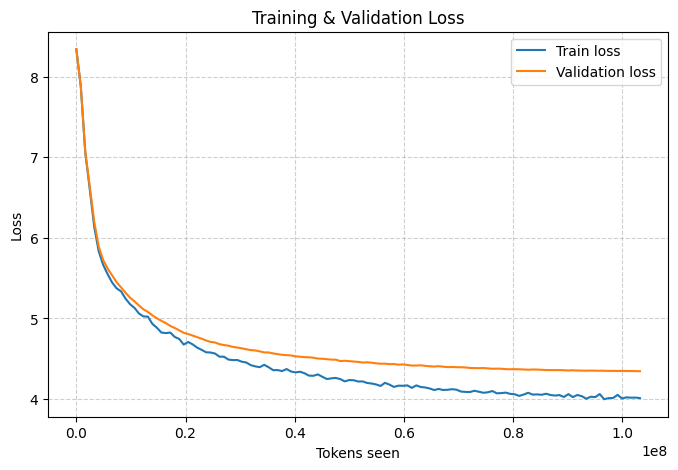

In [34]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, tokens_seen_track):
    plt.figure(figsize=(8,5))
    plt.plot(tokens_seen_track, train_losses, label="Train loss", )
    plt.plot(tokens_seen_track, val_losses, label="Validation loss")
    plt.xlabel("Tokens seen")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Example:
plot_losses(train_losses, val_losses, tokens_seen)


Finetune On ColdPlay

In [35]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import math

# Coldplay data (from your earlier processing)
# train_lyrics = joined_train_lyrics (first 90 songs)
# test_lyrics = joined_test_lyrics (remaining songs)

# Settings for fine-tuning (adjusted for smaller dataset and to avoid overfitting)
settings_ft = {
    "learning_rate": 1e-5,          # Lower LR for fine-tuning to preserve pretrained weights
    "weight_decay": 0.01,           # Reduced weight decay
    "num_epochs": 5,                # Fewer epochs since Coldplay dataset is small
    "batch_size": 4,                # Smaller batch size for small dataset
    "warmup_steps": 100,            # Shorter warmup
    "max_lr": 1e-5,
    "min_lr": 1e-6,
    "eval_freq": 50,                # Evaluate more frequently
    "eval_iter": 5,                 # Smaller eval batches
    "gradient_clip": 0.5,           # gentler clipping
    "patience": 3,                  # Earlier stopping if no improvement
    "min_improvement": 1e-4,
    "print_interval": 1,
    "generate_interval": 2
}

# Create dataloaders for Coldplay (use smaller stride for more samples from small data)
context_length = 128  # Same as pretraining
train_dataloader_ft = create_encoded_dataloader(
    joined_train_lyrics,
    tokenizer=tokenizer,
    batch_size=settings_ft["batch_size"],
    max_length=context_length,
    stride=32,  # Smaller stride for overlapping windows to increase effective samples
    shuffle=True,
    drop_last=True
)

val_dataloader_ft = create_encoded_dataloader(
    joined_test_lyrics,
    tokenizer=tokenizer,
    batch_size=settings_ft["batch_size"],
    max_length=context_length,
    stride=32,
    shuffle=False,
    drop_last=False  # Don't drop last for small val set
)

print(f"Number of batches in fine-tune train dataloader: {len(train_dataloader_ft)}")
print(f"Number of batches in fine-tune val dataloader: {len(val_dataloader_ft)}")

# Reinitialize optimizer and scheduler for fine-tuning (don't load pretrained optimizer)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=settings_ft["learning_rate"],
    weight_decay=settings_ft["weight_decay"],
    betas=(0.9, 0.95)
)

total_steps_ft = settings_ft["num_epochs"] * len(train_dataloader_ft)
scheduler = CosineWithWarmup(
    optimizer,
    warmup_steps=settings_ft["warmup_steps"],
    total_steps=total_steps_ft,
    base_lr=settings_ft["max_lr"],
    min_lr=settings_ft["min_lr"]
)

# Fine-tune using the same training loop
train_losses_ft, val_losses_ft, tokens_seen_ft = train_model(
    model,
    train_dataloader_ft,
    val_dataloader_ft,
    tokenizer,
    device,
    settings=settings_ft,
    context_length=context_length,
    save_path="checkpoints/gpt_512_512_8_8_finetuned_coldplay.pt",
    sample_prompt="Look at the star look how they  "
)

print("Fine-tuning complete.")

Number of batches in fine-tune train dataloader: 219
Number of batches in fine-tune val dataloader: 25


TypeError: train_model() got multiple values for argument 'settings'

In [36]:
# Generate text using the trained model and the generate_text function
start_context = "I want something"
num_chars_to_generate = 500 # You can adjust this number
generated_tokens = generate(
    model=model,
    max_new_tokens=num_chars_to_generate,
    context=text_to_token_ids(start_context, tokenizer, device),
    context_length=context_length,
    temperature=0.8, # Adjust temperature for creativity
    top_k=None # Or specify a top_k value
)

print("Generated Text:")
decoded_text = token_ids_to_text(generated_tokens, tokenizer)

print(decoded_text.replace("\n", " "))

Generated Text:
 thought it was actually entertaining. i am both gay, but by god it's not the dumbest weight of your life. I heard that of the family was the two previous movie were bad, and the story was that that I knew they had to handle out of a film. It was just the first time I'd have to worry but I can't move for a lot more interesting. This movie has some bad moments, but the directing, the characters were very very bad, and the don't be sure it's not that bad.<br /><br />The only thing I watched that was because I didn't give this movie


Character Tokenizer

In [37]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import math
import os

full_text = train_text_data + '\n' + test_text_data

characters = list(set(full_text))

int_to_char = {}
for i, char in enumerate(characters):
    int_to_char[i] = char

char_to_int = {}

for value, char  in int_to_char.items():
    char_to_int[char] = value

print(int_to_char,char_to_int,end="\t")

{0: 'T', 1: '!', 2: '9', 3: 'N', 4: '|', 5: 'D', 6: ')', 7: ']', 8: 'Y', 9: '0', 10: '8', 11: 's', 12: 'R', 13: '^', 14: '?', 15: '~', 16: 'u', 17: '{', 18: '5', 19: '[', 20: 'k', 21: ':', 22: '\x10', 23: 'G', 24: 'f', 25: 'S', 26: '(', 27: 'b', 28: 'E', 29: 'H', 30: 'h', 31: 'o', 32: ';', 33: 'p', 34: 'n', 35: 'X', 36: '<', 37: "'", 38: 'B', 39: 'q', 40: 't', 41: 'd', 42: '}', 43: '1', 44: '`', 45: 'r', 46: '"', 47: 'V', 48: '#', 49: '7', 50: '2', 51: '$', 52: 'W', 53: '.', 54: 'z', 55: 'C', 56: 'I', 57: 'v', 58: 'K', 59: 'a', 60: 'c', 61: 'g', 62: 'U', 63: '6', 64: '\n', 65: ' ', 66: '*', 67: '@', 68: 'J', 69: '%', 70: 'y', 71: 'x', 72: '=', 73: '\\', 74: '-', 75: 'L', 76: '+', 77: '4', 78: '3', 79: 'F', 80: '_', 81: 'O', 82: 'l', 83: '>', 84: '/', 85: '&', 86: 'Z', 87: 'Q', 88: 'w', 89: ',', 90: 'A', 91: 'm', 92: 'i', 93: 'e', 94: 'M', 95: 'j', 96: 'P'} {'T': 0, '!': 1, '9': 2, 'N': 3, '|': 4, 'D': 5, ')': 6, ']': 7, 'Y': 8, '0': 9, '8': 10, 's': 11, 'R': 12, '^': 13, '?': 14, '~': 

In [38]:


encoded_train = [char_to_int[c] for c in train_text_data if c in char_to_int]

encoded_test = [char_to_int[c] for c in test_text_data if c in char_to_int]

print(len(encoded_train),len(encoded_test))

13090602 12929994


In [ ]:

# context_length=3
# encoded= [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

def create_dataset(encoded, context_length=128):
  inputs, targets = [], []
  for i in range(len(encoded) - context_length):
    inputs.append(encoded[i:i+context_length])
    targets.append(encoded[i+1:i+context_length+1])
  return torch.tensor(inputs), torch.tensor(targets)

train_inputs, train_targets = create_dataset(encoded_train)
test_inputs, test_targets = create_dataset(encoded_test)



In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    criterion = nn.CrossEntropyLoss()
    logits = model(input_batch)  # [B, T, V]
    B, T, V = logits.shape
    loss = criterion(logits.view(B*T, V), target_batch.view(B*T))
    return loss


@torch.no_grad()
def calc_loss_loader(data_loader, model, device, num_batches=None):
    if len(data_loader) == 0:
        return float("nan")
    total_loss = 0.0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    model.eval()
    for i, (inp, tgt) in enumerate(data_loader):
        if i >= num_batches:
            break
        loss = calc_loss_batch(inp, tgt, model, device)
        total_loss += loss.item()
    model.train()
    return total_loss / num_batches


@torch.no_grad()
def evaluate_model(model, train_loader, val_loader, device, eval_iter=1):
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
    val_loss   = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    return train_loss, val_loss


# ---------- Cosine LR with Warmup ----------
class CosineWithWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, base_lr, min_lr, last_epoch=-1):
        self.warmup_steps = max(1, warmup_steps)
        self.total_steps = max(self.warmup_steps+1, total_steps)
        self.base_lr = base_lr
        self.min_lr = min_lr
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        step = self.last_epoch + 1
        lrs = []
        for _ in self.base_lrs:
            if step <= self.warmup_steps:
                lr = self.base_lr * step / self.warmup_steps
            else:
                progress = (step - self.warmup_steps) / max(1, self.total_steps - self.warmup_steps)
                lr = self.min_lr + 0.5 * (self.base_lr - self.min_lr) * (1 + math.cos(math.pi * progress))
            lrs.append(lr)
        return lrs


# ---------- Training Loop ----------
def train_model_char(
    model,
    train_inputs,
    train_targets,
    test_inputs,
    test_targets,
    device,
    settings,
    context_length,
    save_path="checkpoints/char_gpt.pt",
):
    """
    Character-level GPT training loop using FP32.
    """

    torch.manual_seed(123)
    model.to(device)
    model.train()

    vocab_size = model.vocab_size  # assume defined in model

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=settings["learning_rate"],
        weight_decay=settings["weight_decay"],
        betas=(0.9, 0.95)
    )

    train_loader = DataLoader(
        TensorDataset(train_inputs, train_targets),
        batch_size=settings["batch_size"], shuffle=True, pin_memory=True
    )
    val_loader = DataLoader(
        TensorDataset(test_inputs, test_targets),
        batch_size=settings["batch_size"], shuffle=True, pin_memory=True
    )

    total_steps = settings["num_epochs"] * len(train_loader)
    scheduler = CosineWithWarmup(
        optimizer,
        warmup_steps=settings["warmup_steps"],
        total_steps=total_steps,
        base_lr=settings["max_lr"],
        min_lr=settings["min_lr"]
    )

    train_losses, val_losses, tokens_seen_track = [], [], []

    tokens_seen = 0
    global_step = -1
    best_val_loss = float("inf")
    patience_counter = 0

    for epoch in range(settings["num_epochs"]):
        for step, (inp, tgt) in enumerate(train_loader):
            loss = calc_loss_batch(inp, tgt, model, device)
            loss.backward()

            # gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), settings["gradient_clip"])

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()
            global_step += 1
            tokens_seen += inp.numel()

            # periodic evaluation
            if (global_step % settings["eval_freq"]) == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device,
                    eval_iter=settings["eval_iter"]
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                tokens_seen_track.append(tokens_seen)
                lr_now = optimizer.param_groups[0]["lr"]

                print(f"Ep {epoch+1} | step {global_step:06d} | lr {lr_now:.3e} "
                      f"| train {train_loss:.3f} | val {val_loss:.3f}")

                # early stopping
                if val_loss + settings["min_improvement"] < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)
                    torch.save({"model_state": model.state_dict(),
                                "optimizer_state": optimizer.state_dict(),
                                "epoch": epoch,
                                "global_step": global_step}, save_path)
                    print(f"[Checkpoint saved at step {global_step}]")
                else:
                    patience_counter += 1
                    if patience_counter >= settings["patience"]:
                        print("Early stopping triggered.")
                        return train_losses, val_losses, tokens_seen_track

    return train_losses, val_losses, tokens_seen_track


In [ ]:
vocab_size = 83          # GPT-2 tokenizer vocab size
context_length = 256                     # Reduced context length for faster training
embed_dim = 512                        # Smaller embedding dimension
attention_dim = 512                     # Keep same as embed_dim
num_heads = 8                           # Divisible by attention_dim
num_blocks = 8                          # Fewer blocks for smaller model
dropout_rate = 0.2

# Initial context (starting token or BOS)
context = torch.zeros(1, 1, dtype=torch.int64).to(device)

model = GPT(num_heads,vocab_size,embed_dim,attention_dim,num_blocks,context_length, dropout_rate).to(device)
#model.load_state_dict(torch.load("/content/trained_model-128-85.pth", weights_only=False))

train_losses, val_losses, tokens_seen_track = train_model_char(
    model,
    train_inputs,
    train_targets,
    test_inputs,
    test_targets,
    device,
    settings,
    settings["context_length"],
    save_path="checkpoints/char_gpt.pt",
)

# Save the trained model
model_path = "trained_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


from google.colab import files
files.download('trained_model.pth')

Extras

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), losses, marker='o')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), accuracies, marker='o', color='green')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
# Training parameters
num_epochs = 10
eval_freq = 50  # Evaluate every 50 batches
eval_iter = 5   # Evaluate on 5 batches for training and validation loss calculation
learning_rate = 0.001
start_context = "The" # Starting text for generation

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Start training
train_losses, val_losses = train_model(
    model, train_dataloader, test_dataloader, optimizer, device,
    num_epochs, eval_freq, eval_iter, start_context, tokenizer, context_length
)

In [ ]:
#GROK CODE
import torch
import torch.nn.functional as F
from torch.optim import AdamW

# Assuming tokenizer is defined as tiktoken.get_encoding("gpt2")
# and device is defined, e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model, train_dataloader, test_dataloader are already defined as per your code

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device, non_blocking=True)
    target_batch = target_batch.to(device, non_blocking=True)
    logits = model(input_batch)
    loss = F.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

# Adjusted generate_text to use tokenizer for decoding
def generate_text(model, new_chars, context, context_length, tokenizer, temperature=1.0, top_k=None):
    generated_tokens = []
    for _ in range(new_chars):
        if context.shape[1] > context_length:
            context = context[:, -context_length:]
        logits = model(context)[:, -1, :]
        logits = logits / max(temperature, 1e-3)
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        if torch.isnan(logits).any() or torch.isinf(logits).any():
            raise ValueError("Logits contain NaN or Inf")
        probabilities = F.softmax(logits, dim=-1)
        probabilities = torch.clamp(probabilities, min=1e-9, max=1.0)
        next_token = torch.multinomial(probabilities, 1)
        context = torch.cat((context, next_token), dim=1)
        generated_tokens.append(next_token.item())
    return tokenizer.decode(generated_tokens)

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context = text_to_token_ids(start_context, tokenizer).to(device, non_blocking=True)
    context_length = model.positional_embedding.num_embeddings
    generated = generate_text(
        model=model,
        new_chars=50,
        context=context,
        context_length=context_length,
        tokenizer=tokenizer,
        temperature=0.5,
        top_k=10
    )
    print(start_context + generated)
    model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen = 0
    global_step = -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

# Example usage:
optimizer = AdamW(model.parameters(),
        lr=settings["learning_rate"],
        weight_decay=settings["weight_decay"],
        betas=(0.9, 0.95))

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_dataloader, test_dataloader, optimizer, device,
    num_epochs=10, eval_freq=100, eval_iter=5,
    start_context="Every movie is a", tokenizer=tokenizer
)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

def debug_model_and_data(model, train_dataloader, tokenizer, device):
    """Comprehensive debugging of model and data"""
    print("="*60)
    print("DEBUGGING MODEL AND DATA")
    print("="*60)

    # 1. Check data
    print("\n1. DATA ANALYSIS:")
    for batch_idx, (input_batch, target_batch) in enumerate(train_dataloader):
        if batch_idx == 0:  # Check first batch
            print(f"Input shape: {input_batch.shape}")
            print(f"Target shape: {target_batch.shape}")
            print(f"Input sample: {input_batch[0][:20]}")  # First 20 tokens
            print(f"Target sample: {target_batch[0][:20]}")

            # Decode to check if data makes sense
            sample_text = tokenizer.decode(input_batch[0][:50].tolist())
            print(f"Decoded sample: '{sample_text}'")

            # Check for data issues
            print(f"Input min/max: {input_batch.min()}/{input_batch.max()}")
            print(f"Vocab size: {tokenizer.n_vocab}")
            if input_batch.max() >= tokenizer.n_vocab:
                print("❌ ERROR: Token IDs exceed vocab size!")
                return False
            break

    # 2. Check model architecture
    print("\n2. MODEL ARCHITECTURE:")
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # 3. Check model forward pass
    print("\n3. FORWARD PASS CHECK:")
    model.eval()
    with torch.no_grad():
        sample_input = input_batch[:1].to(device, non_blocking=True)  # Single sample
        try:
            output = model(sample_input)
            print(f"Model output shape: {output.shape}")
            print(f"Output range: {output.min():.4f} to {output.max():.4f}")

            # Check for NaN/Inf
            if torch.isnan(output).any():
                print("❌ ERROR: Model output contains NaN!")
                return False
            if torch.isinf(output).any():
                print("❌ ERROR: Model output contains Inf!")
                return False
            print("✅ Forward pass successful")
        except Exception as e:
            print(f"❌ ERROR in forward pass: {e}")
            return False

    # 4. Check loss calculation
    print("\n4. LOSS CALCULATION:")
    model.train()
    sample_input, sample_target = input_batch[:1].to(device, non_blocking=True), target_batch[:1].to(device, non_blocking=True)

    # Manual loss calculation
    logits = model(sample_input)
    loss = nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), sample_target.view(-1))
    print(f"Sample loss: {loss.item():.4f}")

    # Check what random guessing would give
    random_loss = np.log(tokenizer.n_vocab)
    print(f"Random guessing loss: {random_loss:.4f}")

    if loss.item() > random_loss + 1:
        print("⚠️  WARNING: Loss much higher than random guessing!")
        print("This suggests the model isn't learning properly")

    # 5. Check gradients
    print("\n5. GRADIENT CHECK:")
    loss.backward()

    grad_norms = []
    zero_grads = 0
    total_grads = 0

    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            grad_norms.append(grad_norm)
            if grad_norm == 0:
                zero_grads += 1
            total_grads += 1

    if grad_norms:
        print(f"Average gradient norm: {np.mean(grad_norms):.6f}")
        print(f"Max gradient norm: {np.max(grad_norms):.6f}")
        print(f"Min gradient norm: {np.min(grad_norms):.6f}")
        print(f"Zero gradients: {zero_grads}/{total_grads}")

        if np.mean(grad_norms) < 1e-6:
            print("❌ ERROR: Gradients too small (vanishing gradient problem)")
            return False
        elif np.max(grad_norms) > 100:
            print("❌ ERROR: Gradients too large (exploding gradient problem)")
            return False

    print("✅ All checks passed!")
    return True

In [ ]:
debug_success = debug_model_and_data(model, train_dataloader, tokenizer, device)
